# Sensor Modeling

# This tutorial demonstrates how to model sensor geometries.

## Setup

In [ ]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [3]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
LineString2 = Mathematics.Geometry.D2.Objects.LineString
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Velocity = Physics.Coordinate.Velocity
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
State = Astrodynamics.Trajectory.State
Access = Astrodynamics.Access

---

## Computation

### Environment

In [4]:
environment = Environment.Default() ;

In [5]:
earth = environment.accessCelestialObjectWithName("Earth")

In [6]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [7]:
a = Length.Kilometers(7000.0)
e = 0.0
i = Angle.Degrees(0.0)
raan = Angle.Degrees(0.0)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [8]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)
earth = Environment.Objects.CelestialBodies.Earth.Analytical(epoch)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No, True)

In [9]:
keplerian_model.getClassicalOrbitalElements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         6999999.9999999991 [m]                   
    Eccentricity:                            1.3267272446711252e-16                   
    Inclination:                             0.098876602957656656 [deg]               
    Right ascension of the ascending node:   88.682615344273074 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            11.686893410122007 [deg]                 
----------------------------------------------------------------------------------------------------

First, we need a **Two-Line Element** (TLE) set:

In [10]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

To setup a **SGP4** orbital model:

In [11]:
sgp4_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [12]:
# satellite_orbit = Orbit(keplerian_model, earth)
satellite_orbit = Orbit(sgp4_model, earth)

In [13]:
start_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 1, 1, 1, 0, 0), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [14]:
step = Duration.Minutes(1.0)

In [15]:
instants = interval.generateGrid(step)

In [16]:
states = [satellite_orbit.getStateAt(instant) for instant in instants]

In [17]:
states_lla = [LLA.Cartesian(state.inFrame(Frame.ITRF()).getPosition().getCoordinates(), Earth.EquatorialRadius, Earth.Flattening) for state in states]

In [18]:
states_line_string = LineString2([Point2(state_lla.getLongitude().inDegrees(), state_lla.getLatitude().inDegrees()) for state_lla in states_lla])

In [19]:
ground_track_df = pd.DataFrame([[float(state_lla.getLongitude().inDegrees()), float(state_lla.getLatitude().inDegrees())] for state_lla in states_lla], columns=['Longitude', 'Latitude']) ;

In [20]:
ground_track_df.head()

,Longitude,Latitude
0,-105.144161,-41.239161
1,-101.013621,-43.362873
2,-96.581238,-45.306468


### Sensor

In [21]:
ned_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.NED)

In [22]:
def calculate_intersection (state, frame, sensor):
    
    observer_geometry_NED = Geometry(sensor, frame)
    
    observer_geometry_ITRF = observer_geometry_NED.inFrame(Frame.ITRF(), state.getInstant())
    
    intersection_ITRF = observer_geometry_ITRF.intersectionWith(earth_geometry)
    
    return intersection_ITRF

In [23]:
apex = Point3(0.0, 0.0, 0.0)
base = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid = Pyramid(base, apex)

In [24]:
intersections_ITRF = [calculate_intersection(state, ned_frame, pyramid) for state in states]

In [25]:
# intersections_ITRF

In [26]:
intersection_pointss = [[Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]] for intersection_ITRF in intersections_ITRF]

In [27]:
# intersection_pointss

In [28]:
intersection_dfs = [pd.DataFrame([[intersection_point.x(), intersection_point.y()] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) for intersection_points in intersection_pointss] ;

In [29]:
intersection_dfs[0].head()

,Longitude,Latitude
0,-110.875073,-45.157963
1,-109.269306,-45.148224
2,-107.940996,-45.142562
3,-106.768734,-45.139369
4,-105.677313,-45.137918


In [30]:
# intersection_ITRF = observer_geometry.intersectionWith(earth_geometry)

In [31]:
# intersection_points = [Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]]

In [32]:
# intersection_polygon = Polygon2(intersection_points)

In [33]:
# intersection_df = pd.DataFrame([[intersection_point.x(), intersection_point.y()] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) ;

In [34]:
# intersection_df.head()

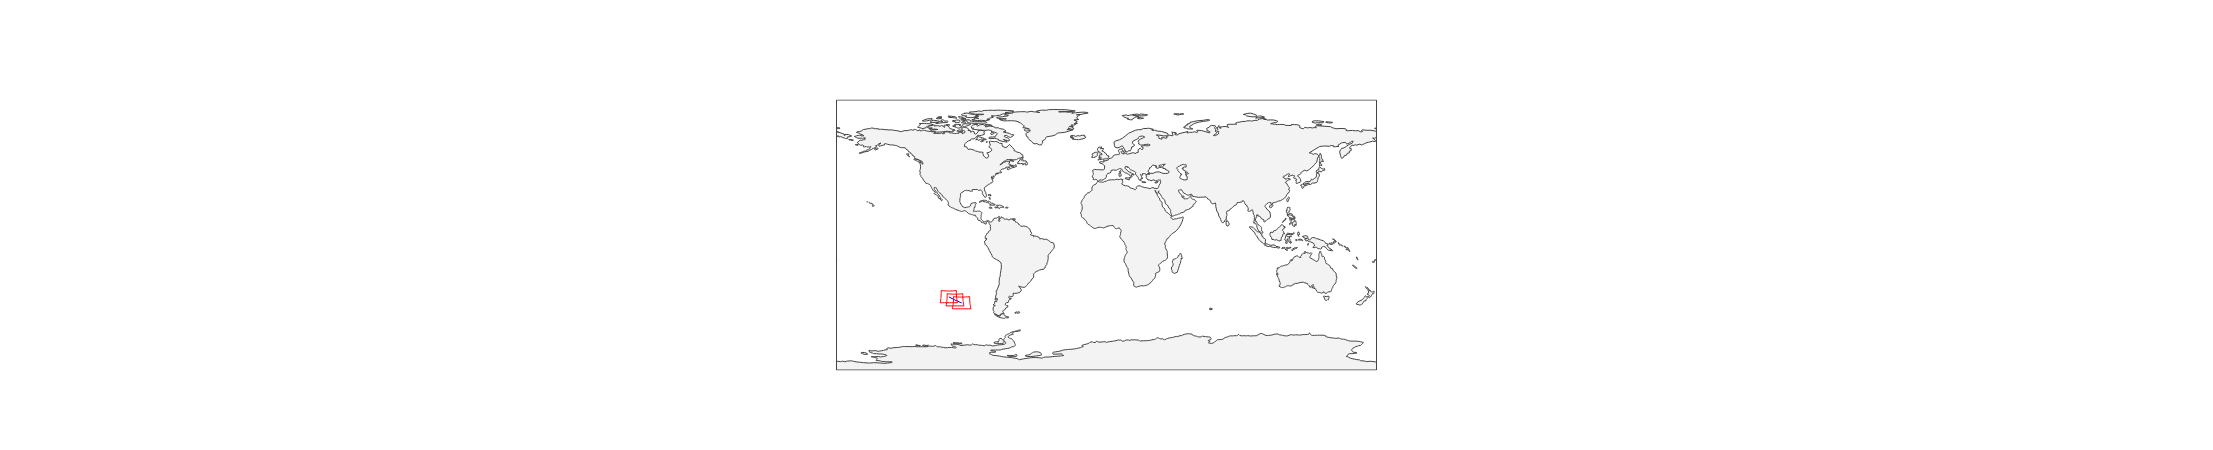

In [35]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'blue',
        )
    )
)

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
) for intersection_df in intersection_dfs]
    
layout = dict(
        title = None,
        showlegend = False, 
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)